
# FER2013 — Binary Emotion Classifier (Happy vs Sad)
**Ready for Google Colab.**  
This notebook loads the FER2013 dataset (`emotion,pixels,Usage`) and trains a CNN to classify **Happy** vs **Sad**.

**Notes**
- Filters the dataset to emotions **3=Happy** and **4=Sad** only.
- Remaps labels to: **0 = Sad**, **1 = Happy**.
- Uses class weights to handle imbalance.
- Includes training curves, confusion matrix, random predictions, and Grad-CAM.


In [1]:
!pip install -q kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir "/content/drive/MyDrive/Colab Notebooks/EmotionDetection"

In [3]:
!mkdir "/content/drive/MyDrive/Colab Notebooks/EmotionDetection/Models"

In [3]:
%cd "/content/drive/MyDrive/Colab Notebooks/EmotionDetection"
!pwd

/content/drive/MyDrive/Colab Notebooks/EmotionDetection
/content/drive/MyDrive/Colab Notebooks/EmotionDetection


In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets list

ref                                                        title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
mosapabdelghany/medical-insurance-cost-dataset             Medical Insurance Cost Dataset                        16425  2025-08-24 11:54:36.533000          11665        228  1.0              
zadafiyabhrami/global-crocodile-species-dataset            Global Crocodile Species Dataset                      57473  2025-08-26 08:46:11.950000           7805        226  1.0              
codebynadiia/gdp-per-country-20202025                      GDP per Country 2020–2025                              5677  2025-09-04 14:37:43.563000           6518        122  1.0              
yashdevladdha/uber-ride-analytics-dashbo

In [ ]:
!kaggle datasets download -d deadskull7/fer2013

In [8]:
!ls
!pwd

Dataset  fer2013.zip  kaggle.json  Models  working
/content/drive/MyDrive/Colab Notebooks/EmotionDetection


In [9]:

# ===== Core =====
import os, gc, glob, json, math, random, time
import numpy as np
import pandas as pd

# ===== Visualization (matplotlib only; no seaborn) =====
import matplotlib.pyplot as plt

# ===== ML / Metrics =====
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# ===== Deep Learning =====
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ===== Reproducibility =====
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print('TensorFlow:', tf.__version__)
print('GPU Available:', tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:

# ===== Locate fer2013.csv =====
SEARCH_DIRS = ['.', './Dataset', './data', '/content', '/content/drive', '/kaggle/input']
csv_candidates = []

for d in SEARCH_DIRS:
    csv_candidates += glob.glob(os.path.join(d, '**', 'fer2013.csv'), recursive=True)

if not csv_candidates:
    raise FileNotFoundError("Couldn't find fer2013.csv. Upload it to Colab (e.g., /content) or mount Google Drive.")

CSV_PATH = csv_candidates[0]
print('Using:', CSV_PATH)


Using: ./Dataset/fer2013.csv


In [11]:

# ===== Load CSV =====
df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())

# Expecting columns: 'emotion','pixels','Usage'
assert {'emotion','pixels','Usage'}.issubset(df.columns), 'CSV must contain emotion,pixels,Usage'
display(df.head())


Shape: (35887, 3)
Columns: ['emotion', 'pixels', 'Usage']


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [12]:

# ===== Keep only Happy(3) and Sad(4) =====
BIN_KEEP = [3, 4]          # FER2013 standard
EMOTION_MAP_FULL = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

df_bin = df[df['emotion'].isin(BIN_KEEP)].copy()

# Map to binary: 0=Sad, 1=Happy
BIN_MAP = {4:0, 3:1}
BIN_LABELS = {0:'Sad', 1:'Happy'}

df_bin['bin_label'] = df_bin['emotion'].map(BIN_MAP).astype(int)
print('Counts (All usages):')
print(df_bin['bin_label'].map(BIN_LABELS).value_counts())


Counts (All usages):
bin_label
Happy    8989
Sad      6077
Name: count, dtype: int64


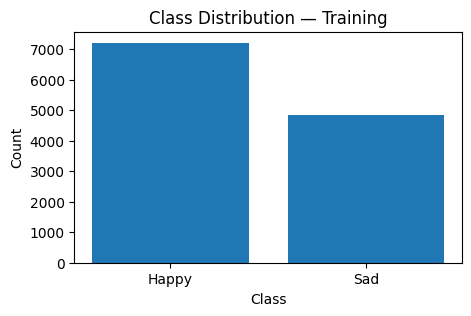

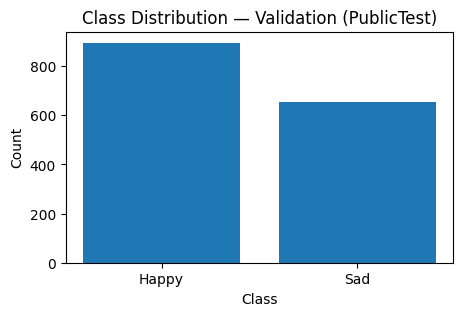

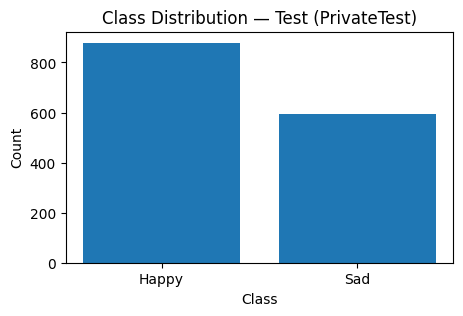

In [13]:

# ===== Distribution per Usage =====
def plot_counts(frame, title):
    counts = frame['bin_label'].map({0:'Sad',1:'Happy'}).value_counts()
    fig = plt.figure(figsize=(5,3))
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_counts(df_bin[df_bin['Usage']=='Training'], 'Class Distribution — Training')
plot_counts(df_bin[df_bin['Usage']=='PublicTest'], 'Class Distribution — Validation (PublicTest)')
plot_counts(df_bin[df_bin['Usage']=='PrivateTest'], 'Class Distribution — Test (PrivateTest)')


In [14]:

# ===== Pixels to arrays =====
IMG_W = IMG_H = 48

def pixels_to_array(pixels_str):
    arr = np.fromstring(pixels_str, dtype=np.uint8, sep=' ')
    return arr.reshape(IMG_H, IMG_W, 1)

# Split by Usage
train_df = df_bin[df_bin['Usage'] == 'Training'].copy()
val_df   = df_bin[df_bin['Usage'] == 'PublicTest'].copy()     # validation
test_df  = df_bin[df_bin['Usage'] == 'PrivateTest'].copy()    # test

def build_Xy(frame):
    X = np.stack(frame['pixels'].apply(pixels_to_array).values)
    y = frame['bin_label'].values
    return X, y

X_train, y_train = build_Xy(train_df)
X_val,   y_val   = build_Xy(val_df)
X_test,  y_test  = build_Xy(test_df)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)


Shapes: (12045, 48, 48, 1) (1548, 48, 48, 1) (1473, 48, 48, 1)


In [15]:

# ===== Normalize =====
X_train = X_train.astype('float32') / 255.0
X_val   = X_val.astype('float32') / 255.0
X_test  = X_test.astype('float32') / 255.0

NUM_CLASSES = 2
y_train_cat = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_cat   = keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test_cat  = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Class weights
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(NUM_CLASSES),
    y=y_train
)
class_weights = {i: float(w) for i, w in enumerate(class_weights_arr)}
print('Class Weights:', class_weights, '(0=Sad, 1=Happy)')


Class Weights: {0: 1.2468944099378882, 1: 0.8347193347193347} (0=Sad, 1=Happy)


In [16]:

# ===== Data Augmentation =====
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name='data_augmentation')


In [17]:

# ===== Model =====
def build_model(input_shape=(48,48,1), num_classes=2):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)

    # Block 3
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.30)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='EmotionCNN_Binary')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()


Model: "EmotionCNN_Binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 322,786 (1.23 MB)

 Trainable params: 321,378 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [18]:

# ===== Train =====
CKPT_DIR = 'Models' if os.path.exists('Models') else '.'
ckpt_path = os.path.join(CKPT_DIR, 'best_emotion_binary.keras')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor='val_accuracy', save_best_only=True, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
]

BATCH_SIZE = 256
EPOCHS = 15

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5272 - loss: 1.0069
Epoch 1: val_accuracy improved from -inf to 0.57817, saving model to Models/best_emotion_binary.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.5273 - loss: 1.0051 - val_accuracy: 0.5782 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/15
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5456 - loss: 0.8370
Epoch 2: val_accuracy did not improve from 0.57817
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.5459 - loss: 0.8359 - val_accuracy: 0.5782 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 3/15
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.5870 - loss: 0.7474
Epoch 3: val_accuracy did not improve from 0.57817
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.5871 - loss: 0.7469 - val_accuracy: 0.5782 - val_loss: 0.7607 - learning_rate: 0.0010
Epoch 4/15
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6195 - loss: 0.6807
Epoch 4: val_accuracy did not

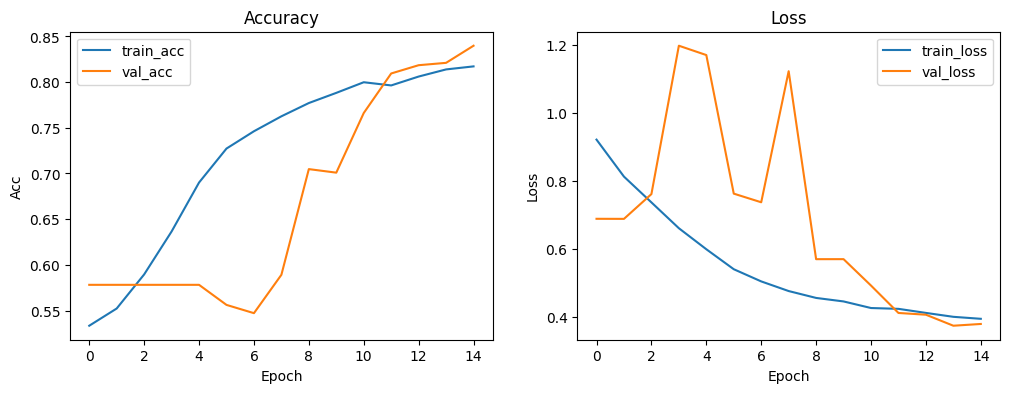

In [19]:

# ===== Plot History =====
def plot_history(h):
    fig = plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.show()

plot_history(history)


Test Accuracy: 0.8289 | Test Loss: 0.3729


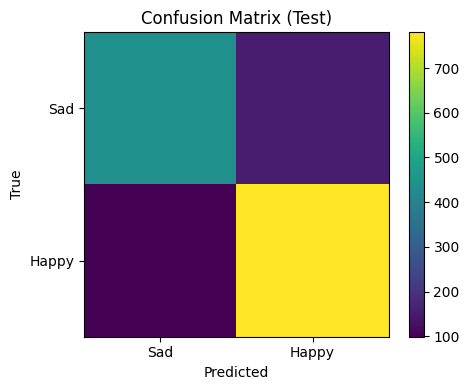

              precision    recall  f1-score   support

         Sad       0.82      0.74      0.78       594
       Happy       0.84      0.89      0.86       879

    accuracy                           0.83      1473
   macro avg       0.83      0.81      0.82      1473
weighted avg       0.83      0.83      0.83      1473



In [20]:

# ===== Evaluate =====
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f'Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}')

# Predictions
y_prob = model.predict(X_test, batch_size=256, verbose=0)
y_pred = y_prob.argmax(axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])  # 0=Sad,1=Happy
fig = plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar()
plt.xticks([0,1], ['Sad','Happy'])
plt.yticks([0,1], ['Sad','Happy'])
plt.tight_layout(); plt.show()

print(classification_report(
    y_test, y_pred,
    target_names=['Sad','Happy']
))


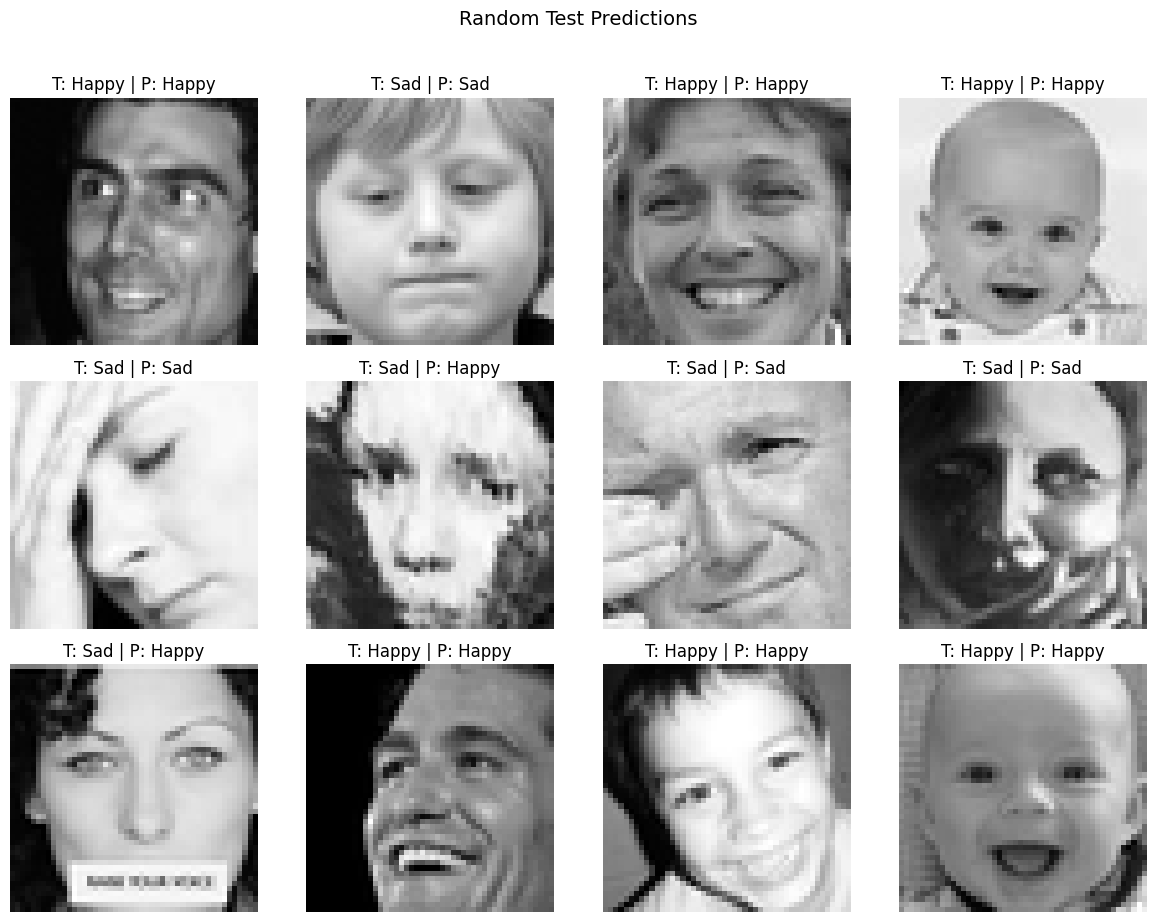

In [21]:

# ===== Random Predictions =====
def show_predictions(X, y_true, y_hat, n=12):
    idxs = np.random.choice(len(X), size=n, replace=False)
    cols = 4; rows = int(np.ceil(n/cols))
    fig = plt.figure(figsize=(12, 3*rows))
    for i, idx in enumerate(idxs, 1):
        img = X[idx].squeeze(axis=-1)
        t, p = ('Happy' if y_true[idx]==1 else 'Sad'), ('Happy' if y_hat[idx]==1 else 'Sad')
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'T: {t} | P: {p}')
        ax.axis('off')
    plt.suptitle('Random Test Predictions', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

show_predictions(X_test, y_test, y_pred, n=12)


Last Conv Layer: conv2d_5


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 48, 48, 1))
  warnings.warn(msg)


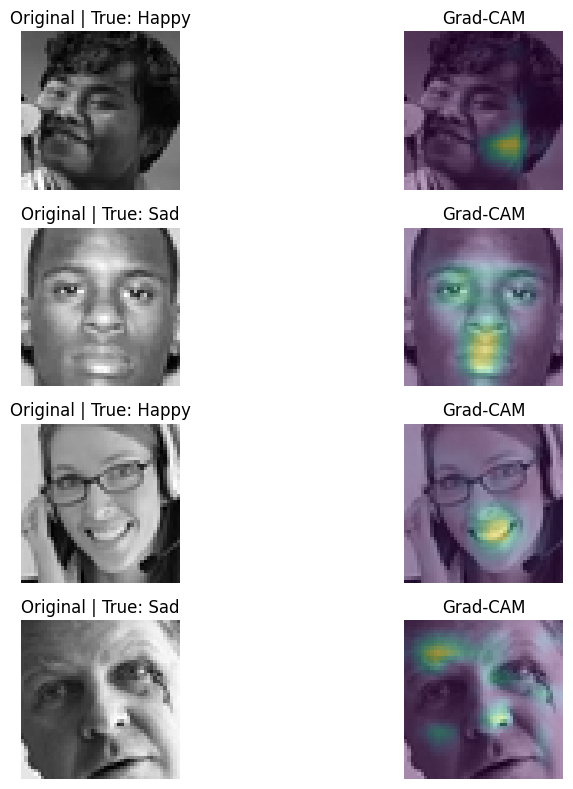

In [22]:

# ===== Grad-CAM =====
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = keras.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(conv_outputs, pooled_grads), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Find last conv layer name automatically
last_conv_name = None
for layer in reversed(model.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv_name = layer.name
        break
print('Last Conv Layer:', last_conv_name)

def plot_gradcam_examples(X, y_true, model, last_conv_layer_name, count=4):
    idxs = np.random.choice(len(X), size=count, replace=False)
    fig = plt.figure(figsize=(10, 2*count))
    for i, idx in enumerate(idxs, 1):
        img = X[idx:idx+1]  # keep batch dims
        heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
        heatmap = np.uint8(255 * heatmap)
        heatmap = np.squeeze(heatmap)

        # Resize heatmap to image size
        heatmap_resized = tf.image.resize(heatmap[...,None], (X.shape[1], X.shape[2])).numpy().squeeze()

        overlay = (img[0].squeeze()*255).astype(np.uint8)

        ax1 = plt.subplot(count, 2, 2*i-1)
        ax1.imshow(overlay, cmap='gray')
        ax1.set_title(f'Original | True: {"Happy" if y_true[idx]==1 else "Sad"}')
        ax1.axis('off')

        ax2 = plt.subplot(count, 2, 2*i)
        ax2.imshow(overlay, cmap='gray')
        ax2.imshow(heatmap_resized, alpha=0.4)
        ax2.set_title('Grad-CAM')
        ax2.axis('off')
    plt.tight_layout()
    plt.show()

plot_gradcam_examples(X_test, y_test, model, last_conv_name, count=4)


In [23]:

# ===== Save Artifacts =====
SAVE_DIR = 'Models' if os.path.exists('Models') else '.'
model.save(os.path.join(SAVE_DIR, 'emotion_binary_final.keras'))
with open(os.path.join(SAVE_DIR, 'label_map_binary.json'), 'w') as f:
    json.dump({0:'Sad',1:'Happy'}, f)

summary = {'test_accuracy': float(test_acc), 'test_loss': float(test_loss)}
with open(os.path.join(SAVE_DIR, 'metrics_binary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print('Saved files in', SAVE_DIR, ':', [p for p in os.listdir(SAVE_DIR) if p.endswith('.keras') or p.endswith('.json')])

# ===== Simple Inference Helper =====
def predict_happy_sad(gray48_image_2d):
    """gray48_image_2d: numpy array shape (48,48), values 0..255"""
    img = gray48_image_2d.astype('float32') / 255.0
    img = img.reshape(1, 48, 48, 1)
    probs = model.predict(img, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    label = 'Happy' if pred_idx==1 else 'Sad'
    return label, float(probs[pred_idx]), probs

# Demo on one test sample
idx = np.random.randint(0, len(X_test))
label, conf, _ = predict_happy_sad((X_test[idx]*255).squeeze())
print('True:', 'Happy' if y_test[idx]==1 else 'Sad', '| Pred:', label, f'({conf:.2f})')


Saved files in Models : ['best_emotion_binary.keras', 'emotion_binary_final.keras', 'label_map_binary.json', 'metrics_binary.json']
True: Happy | Pred: Happy (1.00)


In [24]:
# ===== Export TFLite model and related JSON metadata only =====

import os
import json
import tensorflow as tf

# Set save directory
SAVE_DIR = 'Models' if os.path.exists('Models') else '.'
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Export model to TFLite format (float32)
tflite_path = os.path.join(SAVE_DIR, 'emotion_binary_final.tflite')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)
print(f"[✔] Saved TFLite model: {tflite_path}")

# 2) (Optional) Export smaller FP16 version of TFLite model
try:
    tflite_fp16_path = os.path.join(SAVE_DIR, 'emotion_binary_final_fp16.tflite')
    converter_fp16 = tf.lite.TFLiteConverter.from_keras_model(model)
    converter_fp16.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_fp16.target_spec.supported_types = [tf.float16]
    tflite_model_fp16 = converter_fp16.convert()
    with open(tflite_fp16_path, 'wb') as f:
        f.write(tflite_model_fp16)
    print(f"[✔] Saved FP16 TFLite model: {tflite_fp16_path}")
except Exception as e:
    print("[!] FP16 conversion failed:", e)

# 3) Save label map (for TFLite inference use)
label_map_path = os.path.join(SAVE_DIR, 'emotion_label_map_tflite.json')
label_map = {0: 'Sad', 1: 'Happy'}
with open(label_map_path, 'w') as f:
    json.dump(label_map, f)
print(f"[✔] Saved label map: {label_map_path}")

# 4) Save metrics (accuracy/loss) for documentation
metrics_path = os.path.join(SAVE_DIR, 'emotion_metrics_tflite.json')
summary = {'test_accuracy': float(test_acc), 'test_loss': float(test_loss)}
with open(metrics_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"[✔] Saved test metrics: {metrics_path}")

# 5) Final file summary
def _list_saved(p):
    return [x for x in os.listdir(p) if x.endswith(('.tflite', '.json'))]

print("All exported TFLite-related files:", _list_saved(SAVE_DIR))

Saved artifact at '/tmp/tmpwez20h26'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132083191796688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191803984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191805520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191805904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191803600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191795728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191806288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191806096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191807632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191804368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132083191805328: